# 01 EDA WA1200

Notebook base para EDA y preparacion inicial del dataset WA1200.


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
from pathlib import Path


sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)


In [25]:
def fix_text(s: str) -> str:
    s = str(s)
    replacements = {
        "Mi¿½ltiple": "Multiple",
        "Mï¿½ltiple": "Multiple",
        "M�ltiple": "Multiple",
        "Operaci�n": "Operacion",
        "Reconstrucci�n": "Reconstruccion",
        "Presi�n": "Presion",
        "C�rter": "Carter",
        "Barom�trica": "Barometrica",
        "Admisi�n": "Admision",
        "�ndice": "Indice",
        "Bater�": "Bateria",
        "Sincronizaci": "Sincronizacion",
        "�F": "F",
        "Â°F": "F",
        "ï¿½": "",
        "�": ""
    }
    for bad, good in replacements.items():
        s = s.replace(bad, good)
    s = re.sub(r"\s+", " ", s).strip()
    return s


def normalize_for_match(s: str) -> str:
    s = fix_text(s).lower()
    s = "".join(ch for ch in unicodedata.normalize("NFD", s) if unicodedata.category(ch) != "Mn")
    s = re.sub(r"[^a-z0-9]+", " ", s).strip()
    return s


def merge_name_unit(name: str, unit: str) -> str:
    name = fix_text(name)
    unit = fix_text(unit)

    if unit == "" or unit.lower() == "unidades":
        col = name
    elif name == "":
        col = f"[{unit}]"
    else:
        col = f"{name} [{unit}]"

    # Rule requested: all temperature columns must show [F]
    if "temperatura" in normalize_for_match(col):
        if re.search(r"\[[^\]]*\]", col):
            col = re.sub(r"\[[^\]]*\]", "[F]", col)
        else:
            col = f"{col} [F]"

    return col


def resolve_data_path() -> Path:
    fname = "TL-20240723-202614 WA1200 #05.csv"
    candidates = [
        Path("../data/raw") / fname,
        Path("data/raw") / fname,
        Path("../") / fname,
        Path(fname),
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"CSV not found. Tried: {candidates}")


In [26]:
file_path = resolve_data_path()

# Raw file structure:
# row 19 (1-indexed): variable names
# row 20 (1-indexed): units
# row 21 onward: data
with open(file_path, "r", encoding="utf-8", errors="replace") as f:
    rows = [line.rstrip("\n\r").split(";") for line in f]

if len(rows) < 21:
    raise ValueError("Unexpected file structure. Need at least 21 rows.")

vars_row = [str(x).strip() for x in rows[18]]
units_row = [str(x).strip() for x in rows[19]]

n = max(len(vars_row), len(units_row))
vars_row += [""] * (n - len(vars_row))
units_row += [""] * (n - len(units_row))

new_cols = [merge_name_unit(v, u) for v, u in zip(vars_row, units_row)]

data_rows = []
for r in rows[20:]:
    r = [str(x).strip() for x in r]
    r = (r + [""] * n)[:n]
    data_rows.append(r)

df = pd.DataFrame(data_rows, columns=new_cols)

# Remove trailing fully empty columns generated by ;;;;;
keep_cols = []
for c in df.columns:
    name_empty = str(c).strip() == ""
    col_empty = df[c].astype(str).str.strip().eq("").all()
    if not (name_empty and col_empty):
        keep_cols.append(c)
df = df[keep_cols]

# Remove fully empty rows
df = df[df.astype(str).apply(lambda r: r.str.strip().ne("").any(), axis=1)].reset_index(drop=True)

# If units row leaked by any format variation, drop it
if not df.empty and df.iloc[0].astype(str).str.lower().str.contains("unidades").any():
    df = df.iloc[1:].reset_index(drop=True)

print(f"Loaded: {file_path}")
print(f"Shape: {df.shape}")
display(df.head())


Loaded: ..\data\raw\TL-20240723-202614 WA1200 #05.csv
Shape: (1245, 53)


,Evento,Tiempo Real,Tiempo del Motor,Tiempo de Operacion de Reconstruccion del M [HHHHHH:MM],Velocidad del Motor [rpm],Por Ciento de Pedal o Palanca del Acelerador [Percent],Temperatura del Refrigerante del Motor [F],Sensor de Presion del Refrigeran [in Hg],Presion de Aceite del Mot [psi],Temperatura de Aceite del Motor [F],Presion del Carter del M [pulg. H2O],Presion Pre Filtro de Acei [psi],Presion Post Filtro de Acei [psi],Sensor de Presion Diferencial del Filtro de Aceite (Calculad [in Hg],Presion Barometrica del [in Hg],Temperatura del Aire de Admision del Compresor del Turbocargad [F],Sensor de Temperatura del Combustible [F],Presion del Riel de Combustible Medi [psi],Presion del Riel de Sincronizacion [psi],Indice de Combustible Instantneo [gph],Voltaje 1 de la Bateria [V],Instantaneous Power Output [hp],Sensor de Temperatura de Escape del Cilindro 1 [F],Sensor de Temperatura de Escape del Cilindro 2 [F],Sensor de Temperatura de Escape del Cilindro 3 [F],Sensor de Temperatura de Escape del Cilindro 4 [F],Sensor de Temperatura de Escape del Cilindro 5 [F],Sensor de Temperatura de Escape del Cilindro 6 [F],Sensor de Temperatura de Escape del Cilindro 7 [F],Sensor de Temperatura de Escape del Cilindro 8 [F],Sensor de Temperatura de Escape del Cilindro 9 [F],Sensor de Temperatura de Escape del Cilindro 10 [F],Sensor de Temperatura de Escape del Cilindro 11 [F],Sensor de Temperatura de Escape del Cilindro 12 [F],Sensor de Temperatura de Escape del Cilindro 13 [F],Sensor de Temperatura de Escape del Cilindro 14 [F],Sensor de Temperatura de Escape del Cilindro 15 [F],Sensor de Temperatura de Escape del Cilindro 16 [F],Temperatura Promedio de Escape (Calculada) [F],Temperatura Promedio de Escape - Banco Izquierdo (Calculada) [F],Temperatura Promedio de Escape - Banco Derecho (Calculada) [F],Sensor 1 de Presion del Multiple de Admi [in Hg],Sensor 2 de Presion del Multiple de Admi [in Hg],Sensor 1 de Temperatura del Multiple de Admisi [F],Sensor 2 de Temperatura del Multiple de Admisi [F],Sensor 3 de Temperatura del Multiple de Admisi [F],Sensor 4 de Temperatura del Multiple de Admisi [F],Sensor de Temperatura 1 Delta del Multiple de Admision (Calcul [F],Sensor de Temperatura 2 Delta del Multiple de Admision (Calcul [F],Sensor de Temperatura 3 Delta del Multiple de Admision (Calcul [F],Sensor de Temperatura 4 Delta del Multiple de Admision (Calcul [F],Carga Neta Porcentual [Percent],Estado del Motor
0,1,Sin Preparar,002053:24:49,0002053:24,1820,90,183.2,30,67.9,199.4,5.6,151.3,127.2,49,18.4,77,109.4,148,181.297,79.8,26.4,1247.3,996,972,994,938,986,978,1075,1078,1095,1040,1053,959,968,972,974,1015,985.6,1007.6,983.3,52,52,124,127,125,129,32,33,33,33,66,Funcionando
1,2,Sin Preparar,002053:26:31,0002053:26,1829,100,185,27,68.5,201.8,6.6,157.9,134.3,48,18.4,77,109.4,72,235.686,76.6,26.3,1046.1,967,957,1018,955,1000,960,1075,1072,1079,1058,1041,940,964,956,971,1010,982.9,1006.3,978.8,52,52,129,131,129,133,34,33,33,33,68,Funcionando
2,3,Sin Preparar,002053:27:35,0002053:27,1852,100,188.6,27,69.6,205.4,6,163.4,136.7,55,18.4,77,109.4,80,244.751,69.9,26.4,901.7,952,948,1012,954,994,943,1067,1068,1067,1058,1041,930,965,964,953,995,975.7,995.9,970.3,52,50,135,136,134,138,34,33,33,33,63,Funcionando
3,4,Sin Preparar,002053:28:47,0002053:28,1824,100,190.4,34,66.7,208,7.6,159.6,134.3,52,18.4,77,109.4,143,145.038,77.9,26.5,1573.4,986,980,1026,956,1006,961,1095,1093,1093,1084,1062,960,978,977,992,1028,998.2,1020.7,994.1,53,54,140,141,139,143,34,33,33,33,73,Funcionando
4,5,Sin Preparar,002053:29:55,0002053:29,1819,100,194,32,69,210.3,7.4,158.3,131.5,55,18.4,77,109.4,56,253.816,74,26.5,1544.1,998,981,1020,966,1009,976,1088,1099,1109,1078,1062,951,993,984,978,1002,996.8,1022,992.3,54,55,142,143,141,145,34,33,33,33,100,Funcionando


In [27]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 53 columns):
 #   Column                                                                Non-Null Count  Dtype
---  ------                                                                --------------  -----
 0   Evento                                                                1245 non-null   str  
 1   Tiempo Real                                                           1245 non-null   str  
 2   Tiempo del Motor                                                      1245 non-null   str  
 3   Tiempo de Operacion de Reconstruccion del M [HHHHHH:MM]               1245 non-null   str  
 4   Velocidad del Motor [rpm]                                             1245 non-null   str  
 5   Por Ciento de Pedal o Palanca del Acelerador [Percent]                1245 non-null   str  
 6   Temperatura del Refrigerante del Motor [F]                            1245 non-null   str  
 7   Sensor de Presion del Refr

In [28]:
display(df.describe(include="all").T.head(30))


,count,unique,top,freq
Evento,1245,1245,1,1
Tiempo Real,1245,1,Sin Preparar,1245
Tiempo del Motor,1245,1245,002053:24:49,1
Tiempo de Operacion de Reconstruccion del M [HHHHHH:MM],1245,967,0002081:26,4
Velocidad del Motor [rpm],1245,349,1846,14
Por Ciento de Pedal o Palanca del Acelerador [Percent],1245,31,100,736
Temperatura del Refrigerante del Motor [F],1245,22,188.6,131
Sensor de Presion del Refrigeran [in Hg],1245,43,38,110
Presion de Aceite del Mot [psi],1245,40,67.9,102
Temperatura de Aceite del Motor [F],1245,328,210.6,17


In [29]:
nulls = df.isnull().sum().sort_values(ascending=False)
display(nulls.head(20))


Evento                                                                  0
Tiempo Real                                                             0
Tiempo del Motor                                                        0
Tiempo de Operacion de Reconstruccion del M [HHHHHH:MM]                 0
Velocidad del Motor [rpm]                                               0
Por Ciento de Pedal o Palanca del Acelerador [Percent]                  0
Temperatura del Refrigerante del Motor [F]                              0
Sensor de Presion del Refrigeran [in Hg]                                0
Presion de Aceite del Mot [psi]                                         0
Temperatura de Aceite del Motor [F]                                     0
Presion del Carter del M [pulg. H2O]                                    0
Presion Pre Filtro de Acei [psi]                                        0
Presion Post Filtro de Acei [psi]                                       0
Sensor de Presion Diferencial del Filt

In [30]:
# Convert columns to numeric when most values are numeric-like
for col in df.columns:
    if df[col].dtype != "object":
        continue

    s = df[col].astype(str).str.replace(",", ".", regex=False).str.strip()
    num = pd.to_numeric(s, errors="coerce")

    # Convert only when conversion is meaningful
    if num.notna().mean() >= 0.80:
        df[col] = num

print("Numeric conversion done.")
df.info()


Numeric conversion done.
<class 'pandas.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 53 columns):
 #   Column                                                                Non-Null Count  Dtype
---  ------                                                                --------------  -----
 0   Evento                                                                1245 non-null   str  
 1   Tiempo Real                                                           1245 non-null   str  
 2   Tiempo del Motor                                                      1245 non-null   str  
 3   Tiempo de Operacion de Reconstruccion del M [HHHHHH:MM]               1245 non-null   str  
 4   Velocidad del Motor [rpm]                                             1245 non-null   str  
 5   Por Ciento de Pedal o Palanca del Acelerador [Percent]                1245 non-null   str  
 6   Temperatura del Refrigerante del Motor [F]                            1245 non-null   str  
 7   S

In [31]:
# Helper to find columns by normalized text
norm_map = {col: normalize_for_match(col) for col in df.columns}

fuel_col = None
for col, norm in norm_map.items():
    if "combustible" in norm and ("instantaneo" in norm or "indice" in norm):
        fuel_col = col
        break
if fuel_col is None:
    for col, norm in norm_map.items():
        if "fuel" in norm:
            fuel_col = col
            break

rpm_col = None
for col, norm in norm_map.items():
    if "velocidad" in norm and "motor" in norm:
        rpm_col = col
        break
if rpm_col is None:
    for col, norm in norm_map.items():
        if norm == "rpm" or " rpm " in f" {norm} ":
            rpm_col = col
            break

print("fuel_col:", fuel_col)
print("rpm_col:", rpm_col)

if fuel_col is None:
    raise ValueError("Fuel column not found. Check df.columns manually.")
if rpm_col is None:
    raise ValueError("RPM column not found. Check df.columns manually.")


fuel_col: Indice de Combustible Instantneo [gph]
rpm_col: Velocidad del Motor [rpm]


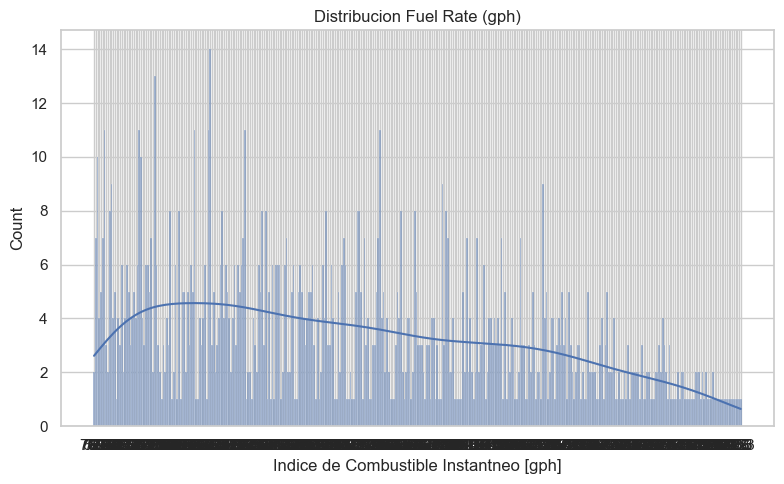

In [32]:
plt.figure(figsize=(8, 5))
sns.histplot(df[fuel_col].dropna(), bins=50, kde=True)
plt.title("Distribucion Fuel Rate (gph)")
plt.xlabel(fuel_col)
plt.tight_layout()
plt.show()


In [33]:
# Forzar fuel_col a numerico antes de calcular quantile
fuel_num = (
    df[fuel_col]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .str.replace(r"[^0-9.\-]", "", regex=True)
    .str.strip()
    .replace("", np.nan)
)

df[fuel_col] = pd.to_numeric(fuel_num, errors="coerce")

if df[fuel_col].notna().sum() == 0:
    raise ValueError(f"{fuel_col} no tiene valores numericos despues de convertir.")

threshold = df[fuel_col].quantile(0.90)
df["High_Consumption"] = np.where(df[fuel_col] > threshold, 1, 0)

print("fuel dtype:", df[fuel_col].dtype)
print("Threshold (p90):", threshold)
print(df["High_Consumption"].value_counts(dropna=False))
print("Class balance (%):")
print((df["High_Consumption"].value_counts(normalize=True) * 100).round(2))



fuel dtype: float64
Threshold (p90): 76.36000000000001
High_Consumption
0    1120
1     125
Name: count, dtype: int64
Class balance (%):
High_Consumption
0    89.96
1    10.04
Name: proportion, dtype: float64


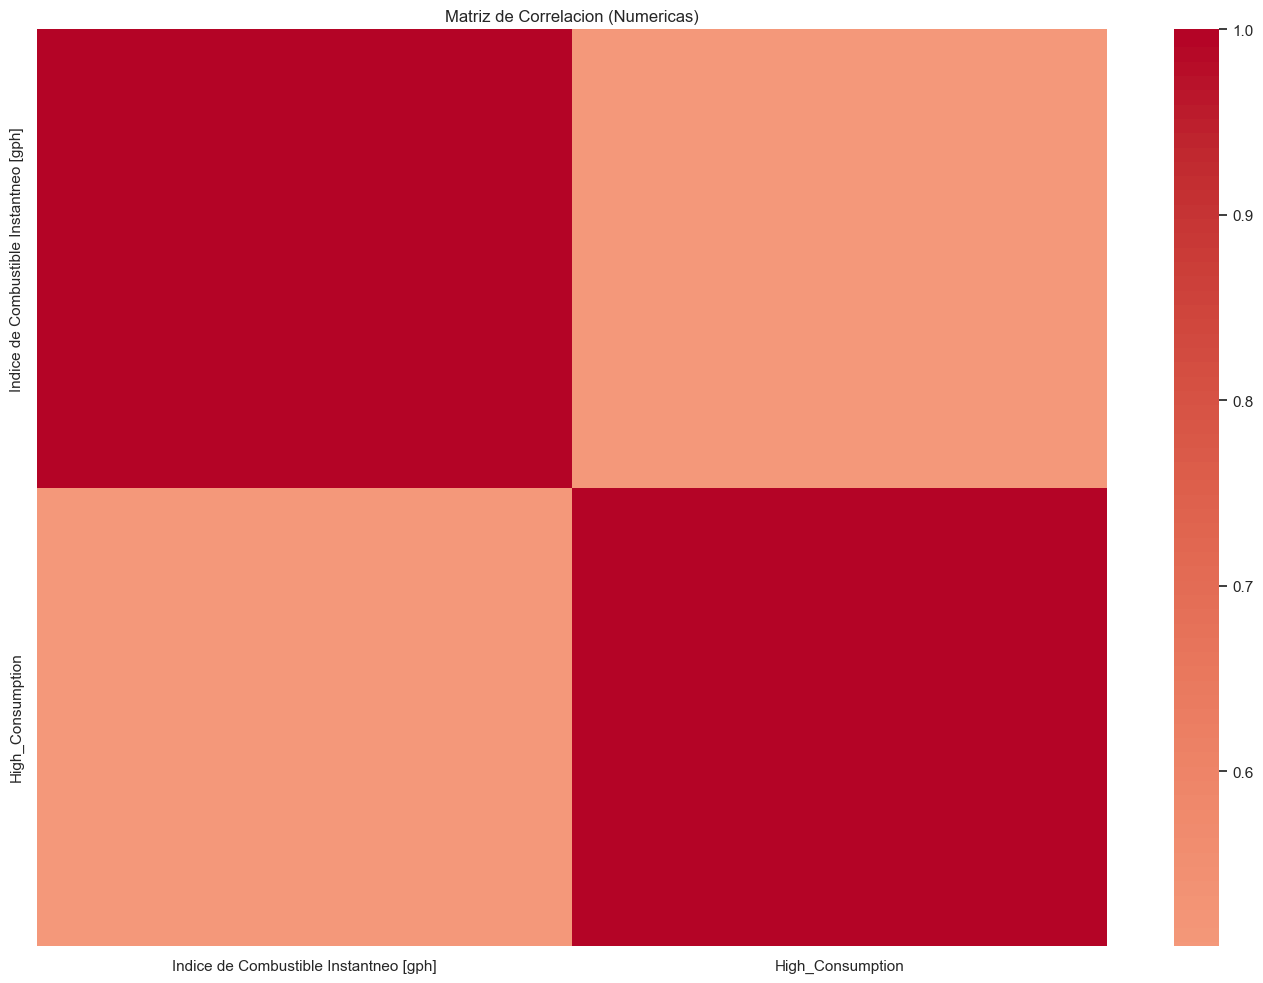

In [34]:
numeric_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", center=0)
plt.title("Matriz de Correlacion (Numericas)")
plt.tight_layout()
plt.show()


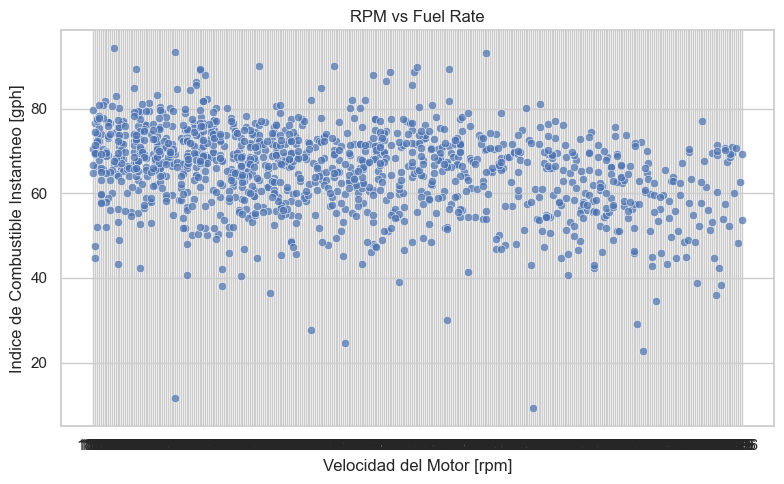

In [35]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df[rpm_col], y=df[fuel_col], alpha=0.7)
plt.title("RPM vs Fuel Rate")
plt.xlabel(rpm_col)
plt.ylabel(fuel_col)
plt.tight_layout()
plt.show()


In [36]:
# Optional: save EDA-ready dataset
out_path = Path("../data/processed/wa1200_eda_ready.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_path, index=False)
print(f"Saved: {out_path.resolve()}")


Saved: C:\Users\robin\Downloads\Trabajo final mlops\data\processed\wa1200_eda_ready.csv


In [37]:
print("shape:", df.shape)
print(df.dtypes.astype(str).value_counts())
print("fuel_col:", fuel_col, "|", df[fuel_col].dtype)
print("rpm_col:", rpm_col, "|", df[rpm_col].dtype)
print(df["High_Consumption"].value_counts())


shape: (1245, 54)
str        52
float64     1
int64       1
Name: count, dtype: int64
fuel_col: Indice de Combustible Instantneo [gph] | float64
rpm_col: Velocidad del Motor [rpm] | str
High_Consumption
0    1120
1     125
Name: count, dtype: int64


## FASE 2 - Limpieza formal, seleccion de features y modelo base

En esta fase vamos a:
1. Preparar un dataframe limpio para modelado.
2. Seleccionar features numericas utiles.
3. Separar train/test con estratificacion.
4. Entrenar modelos base y comparar metricas.
5. Guardar artefactos iniciales.



In [38]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

RANDOM_STATE = 42



In [39]:
# Copia de trabajo para fase 2
model_df = df.copy()

# Asegurar que el objetivo existe
if "High_Consumption" not in model_df.columns:
    raise ValueError("No existe High_Consumption. Ejecuta la fase de EDA completa primero.")

# Funcion robusta de conversion a numerico
def to_num(series: pd.Series) -> pd.Series:
    s = (
        series.astype(str)
        .str.replace(",", ".", regex=False)
        .str.replace(r"[^0-9.\-]", "", regex=True)
        .str.strip()
        .replace("", np.nan)
    )
    return pd.to_numeric(s, errors="coerce")

# Columnas de texto que no se deben forzar a numerico
text_keep_patterns = ["evento", "estado del motor", "tiempo real"]
text_keep = [
    c for c in model_df.columns
    if any(p in str(c).lower() for p in text_keep_patterns)
]

# Intentar convertir columnas string a numerico cuando tenga sentido
for c in model_df.columns:
    if c == "High_Consumption" or c in text_keep:
        continue

    # pandas 3 puede tener dtype 'str'
    if str(model_df[c].dtype) in ("object", "str"):
        num = to_num(model_df[c])
        if num.notna().mean() >= 0.80:
            model_df[c] = num

# Forzar columna RPM a numerico si fue detectada
if "rpm_col" in globals() and rpm_col in model_df.columns:
    model_df[rpm_col] = to_num(model_df[rpm_col])

print("Dtypes despues de limpieza:")
print(model_df.dtypes.astype(str).value_counts())



Dtypes despues de limpieza:
int64      36
float64    15
str         3
Name: count, dtype: int64


In [40]:
# Seleccion de features
# 1) Tomamos solo numericas
num_df = model_df.select_dtypes(include=np.number).copy()

# 2) Objetivo
y = num_df["High_Consumption"].astype(int)

# 3) Features = numericas menos objetivo
X = num_df.drop(columns=["High_Consumption"])

# 3.1) Evitar leakage: excluir columna de fuel usada para crear el target
leak_cols = []
if "fuel_col" in globals() and fuel_col in X.columns:
    leak_cols.append(fuel_col)

# fallback por nombre por si fuel_col no existe en memoria
for c in X.columns:
    norm_c = normalize_for_match(c) if "normalize_for_match" in globals() else str(c).lower()
    if ("combustible" in norm_c and "instantaneo" in norm_c) or "fuel" in norm_c:
        leak_cols.append(c)

leak_cols = sorted(set(leak_cols))
if leak_cols:
    X = X.drop(columns=leak_cols, errors="ignore")

# 4) Eliminar columnas con demasiados nulos (>40%)
missing_ratio = X.isna().mean()
keep_cols = missing_ratio[missing_ratio <= 0.40].index.tolist()
X = X[keep_cols]

# 5) Eliminar columnas con varianza 0
zero_var_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
if zero_var_cols:
    X = X.drop(columns=zero_var_cols)

print("Leak cols removed:", leak_cols)
print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Balance y:")
print(y.value_counts())



Leak cols removed: ['Indice de Combustible Instantneo [gph]']
Shape X: (1245, 48)
Shape y: (1245,)
Balance y:
High_Consumption
0    1120
1     125
Name: count, dtype: int64


In [41]:
# Train/Test split con estratificacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)



Train: (996, 48) (996,)
Test : (249, 48) (249,)


In [42]:
# Modelos base
models = {
    "logreg": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "rf": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_split=2,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1,
        ))
    ]),
}

results = []
fitted_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, proba)
    else:
        auc = np.nan

    row = {
        "model": name,
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds, zero_division=0),
        "recall": recall_score(y_test, preds, zero_division=0),
        "f1": f1_score(y_test, preds, zero_division=0),
        "roc_auc": auc,
    }
    results.append(row)
    fitted_models[name] = model

results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False).reset_index(drop=True)
display(results_df)



,model,accuracy,precision,recall,f1,roc_auc
0,logreg,0.767068,0.26087,0.72,0.382979,0.851429
1,rf,0.899598,0.00000,0.00,0.000000,0.848125


In [43]:
# Detalle del mejor modelo
best_name = results_df.loc[0, "model"]
best_model = fitted_models[best_name]

best_preds = best_model.predict(X_test)
print("Best model:", best_name)
print("\nConfusion matrix:")
print(confusion_matrix(y_test, best_preds))
print("\nClassification report:")
print(classification_report(y_test, best_preds, digits=4))



Best model: logreg

Confusion matrix:
[[173  51]
 [  7  18]]

Classification report:
              precision    recall  f1-score   support

           0     0.9611    0.7723    0.8564       224
           1     0.2609    0.7200    0.3830        25

    accuracy                         0.7671       249
   macro avg     0.6110    0.7462    0.6197       249
weighted avg     0.8908    0.7671    0.8089       249



In [44]:
# Guardar artefactos basicos de fase 2
import json
import joblib

artifacts_dir = Path("../artifacts")
models_dir = artifacts_dir / "models"
meta_dir = artifacts_dir / "meta"
models_dir.mkdir(parents=True, exist_ok=True)
meta_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, models_dir / "baseline_model.joblib")
joblib.dump(list(X.columns), meta_dir / "feature_columns.joblib")

meta = {
    "best_model": best_name,
    "n_rows": int(model_df.shape[0]),
    "n_features": int(X.shape[1]),
    "target": "High_Consumption",
    "metrics": results_df.iloc[0].to_dict(),
}

with open(meta_dir / "baseline_metrics.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("Guardado:")
print(models_dir / "baseline_model.joblib")
print(meta_dir / "feature_columns.joblib")
print(meta_dir / "baseline_metrics.json")



Guardado:
..\artifacts\models\baseline_model.joblib
..\artifacts\meta\feature_columns.joblib
..\artifacts\meta\baseline_metrics.json
